In [2]:
from xtcocotools.coco import COCO
from matplotlib import pyplot as plt
import numpy as np
import json
from shapely.geometry import Point, Polygon
from scipy.spatial import Delaunay


In [5]:
root_data = '/volume/datasets/mp100/'
anno_dir = root_data + 'annotations/'
image_dir = root_data + 'images/'
annotation_file = anno_dir + 'human_face_split.json'
coco = COCO(annotation_file)
img_id = coco.getImgIds()[1]
img_anno = coco.loadImgs(img_id)[0]
ann_ids = coco.getAnnIds(imgIds=img_id)
objs = coco.loadAnns(ann_ids)
skeleton = coco.loadCats(40)[0]['skeleton']

obj = objs[0]
keypoints = obj['keypoints']
keypoints = np.array(keypoints).reshape(-1, 3)[:, :2]

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [5]:
def find_centroid_weight(keypoints, centroids):
    # keypoints: (N, 2) array of 2D points
    # centroids: (M, 2) array of centroid points

    keypoints = np.asarray(keypoints)
    centroids = np.asarray(centroids)

    tri = Delaunay(keypoints)
    results = []

    for centroid in centroids:
        simplex = tri.find_simplex(centroid)
        if simplex == -1:
            raise ValueError("Centroid is not inside any triangle formed by keypoints.")

        triangle_indices = tri.simplices[simplex]
        triangle_points = keypoints[triangle_indices]

        # Compute barycentric coordinates
        T = np.vstack((triangle_points.T, np.ones(3)))
        C = np.append(centroid, 1)
        weights = np.linalg.solve(T, C)

        results.append((triangle_indices.tolist(), weights.tolist()))

    return results

In [6]:
from scipy.spatial import Voronoi, voronoi_plot_2d, Delaunay
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import numpy as np

img = plt.imread(f"{image_dir}/{img_anno['file_name']}")

fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# --- 1. Voronoi diagram ---
vor = Voronoi(keypoints)
ax = axes[0, 0]
# voronoi_plot_2d(vor, ax=ax, show_vertices=False, show_points=False)
ax.imshow(img)
# ax.scatter(keypoints[:, 0], keypoints[:, 1], color='red')
# ax.set_xlim(0, img.shape[1])
# ax.set_ylim(img.shape[0], 0)
# for region in vor.regions:
#     if not -1 in region and len(region) > 0:
#         polygon = [vor.vertices[i] for i in region]
#         ax.fill(*zip(*polygon), alpha=0.2)
ax.axis('off')
# ax.set_title("Voronoi Diagram")

# --- 2. Boundary keypoints ---
bound_kp_ids = [i for i in range(17)] + [i for i in range(26, 16, -1)]
bound_kps = keypoints[bound_kp_ids]

ax = axes[0, 1]
ax.imshow(img)
# ax.scatter(bound_kps[:, 0], bound_kps[:, 1], color='red')
ax.scatter(keypoints[:, 0], keypoints[:, 1], s=20, color='red')
ax.axis('off')
# ax.set_title("Boundary Keypoints")

# --- 3. Sampled points inside polygon ---
k = 5
boundary_polygon = Polygon(bound_kps)
min_x, min_y = bound_kps.min(axis=0)
max_x, max_y = bound_kps.max(axis=0)

samples = []
rng = np.random.default_rng()
while len(samples) < k:
    x = rng.uniform(min_x, max_x)
    y = rng.uniform(min_y, max_y)
    if boundary_polygon.contains(Point(x, y)):
        samples.append([x, y])
samples = np.array(samples)

ax = axes[1, 0]
ax.imshow(img)
# ax.scatter(bound_kps[:, 0], bound_kps[:, 1], color='red', s=10, label='Boundary')
for i, j in skeleton:
    ax.plot([keypoints[i, 0], keypoints[j, 0]], [keypoints[i, 1], keypoints[j, 1]], color='yellow', linewidth=1)
ax.scatter(keypoints[:, 0], keypoints[:, 1], color='red', s=10, label='Boundary', zorder=2)
ax.scatter(samples[:, 0], samples[:, 1], color='blue', s=20, label='Sampled', zorder=3)
ax.axis('off')
# ax.legend()
# ax.set_title("Sampled Points in Polygon")

# --- 4. Delaunay triangulation ---
tri = Delaunay(keypoints)

ax = axes[1, 1]
ax.imshow(img)
ax.triplot(keypoints[:, 0], keypoints[:, 1], tri.simplices, color='gray', linewidth=0.8)
ax.scatter(keypoints[:, 0], keypoints[:, 1], color='red', s=10, label='Keypoints')
ax.scatter(samples[:, 0], samples[:, 1], color='blue', s=10, label='Centroids')

# Highlight triangles containing centroids
for centroid in samples:
    simplex = tri.find_simplex(centroid)
    if simplex != -1:
        triangle_indices = tri.simplices[simplex]
        triangle = keypoints[triangle_indices]
        ax.fill(triangle[:, 0], triangle[:, 1], color='yellow', alpha=0.2)

ax.axis('off')
# ax.legend()
# ax.set_title("Delaunay Triangulation")

for i in range(2):
    for j in range(2):
        ax = axes[i, j]
        extent = ax.get_tightbbox(fig.canvas.get_renderer()).transformed(fig.dpi_scale_trans.inverted())
        fig.savefig(f"tmp/axes_{i}_{j}.svg", format="svg", bbox_inches=extent)

plt.show()


NameError: name 'image_dir' is not defined

In [8]:
# keypoints = prototype.copy()

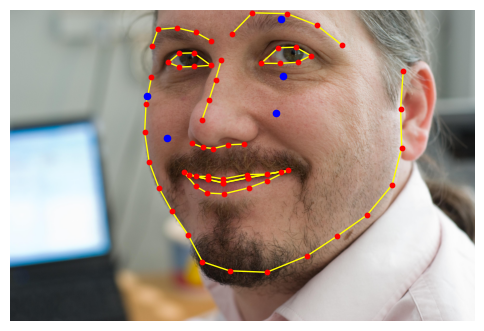

In [9]:
# Load another image and its keypoints
new_img_id = coco.getImgIds()[16]  # pick another image id
new_img_anno = coco.loadImgs(new_img_id)[0]
new_img = plt.imread(f"{image_dir}/{new_img_anno['file_name']}")
new_ann_ids = coco.getAnnIds(imgIds=new_img_id)
new_objs = coco.loadAnns(new_ann_ids)
new_keypoints = np.array(new_objs[0]['keypoints']).reshape(-1, 3)[:, :2]

# Use the same centroids as before (samples)
results = find_centroid_weight(keypoints, samples)

# Compute weighted mean for each centroid
weighted_means = []
for triangle_indices, weights in results:
    pts = new_keypoints[triangle_indices]
    weighted_mean = np.dot(weights, pts)
    weighted_means.append(weighted_mean)
weighted_means = np.array(weighted_means)

# Visualize
plt.figure(figsize=(6, 6))
plt.imshow(new_img)
# for (triangle_indices, _) in results:
#     pts = new_keypoints[triangle_indices]
#     plt.scatter(pts[:, 0], pts[:, 1], color='orange', s=20)
#     plt.plot([pts[0, 0], pts[1, 0]], [pts[0, 1], pts[1, 1]], color='orange', linewidth=1)
#     plt.plot([pts[1, 0], pts[2, 0]], [pts[1, 1], pts[2, 1]], color='orange', linewidth=1)
#     plt.plot([pts[2, 0], pts[0, 0]], [pts[2, 1], pts[0, 1]], color='orange', linewidth=1)
plt.scatter(new_keypoints[:, 0], new_keypoints[:, 1], color='red', s=10, label='Keypoints', zorder=3)
for i, j in skeleton:
    plt.plot([new_keypoints[i, 0], new_keypoints[j, 0]], [new_keypoints[i, 1], new_keypoints[j, 1]], color='yellow', linewidth=1, zorder=2)
plt.scatter(weighted_means[:, 0], weighted_means[:, 1], color='blue', s=20, label='Weighted Mean', zorder=5)
plt.axis('off')
# plt.legend()

plt.savefig("tmp/weighted_means.svg", format="svg", bbox_inches='tight')

plt.show()


In [8]:
import msgpack

with open("result_voronoi_ref_capeformer_s1_5_1_300k_prototype_ori_m90p.msgpack", "rb") as f:
# with open("result_voronoi_2025-10-06_17-32-35.msgpack", "rb") as f:
    result_keypoints = msgpack.load(f)

In [9]:
start_kpts_idx = 68

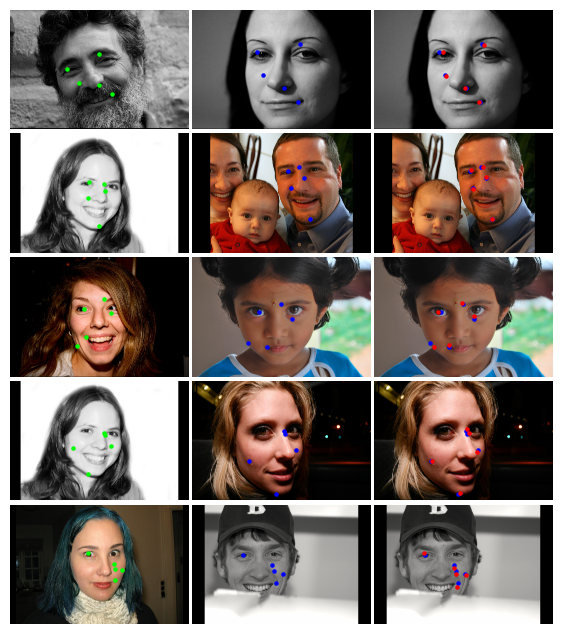

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize


result_ids = [3,6,7,19,29]
# result_ids = [695, 1132]

# --- find max dimensions ---
max_h, max_w = 0, 0
for idx in result_ids:
    result = result_keypoints[idx]
    img_s = imread(result['img_s'][0])
    img_q = imread(result['img_q'])
    max_h = max(max_h, img_s.shape[0], img_q.shape[0])
    max_w = max(max_w, img_s.shape[1], img_q.shape[1])

def resize_and_pad(img, target_h, target_w, keypoints_list):
    """Resize proportionally, then pad to (target_h, target_w)."""
    h, w = img.shape[:2]
    scale = min(target_h / h, target_w / w)
    new_h, new_w = int(h * scale), int(w * scale)

    # resize while preserving aspect ratio
    img_resized = resize(img, (new_h, new_w), preserve_range=True, anti_aliasing=True).astype(np.uint8)

    # adjust keypoints
    for keypoints in keypoints_list:
        keypoints *= scale

    # pad to target size
    pad_h = target_h - new_h
    pad_w = target_w - new_w
    pad_top, pad_bottom = pad_h // 2, pad_h - pad_h // 2
    pad_left, pad_right = pad_w // 2, pad_w - pad_w // 2

    img_padded = np.pad(img_resized,
                        ((pad_top, pad_bottom), (pad_left, pad_right), (0, 0)),
                        mode='constant', constant_values=0)

    # adjust keypoints for padding
    for keypoints in keypoints_list:
        keypoints[:, 0] += pad_left
        keypoints[:, 1] += pad_top

    return img_padded, *keypoints_list

# --- plot grid ---
fig, axes = plt.subplots(len(result_ids), 3, figsize=(7, 8))
axes = np.atleast_2d(axes)

for i, idx in enumerate(result_ids):
    result = result_keypoints[idx]

    target_s = np.array(result['target_s'][0])
    gt = np.array(result['gt'])
    pred = np.array(result['pred'])

    img_s, keypoints_s = resize_and_pad(imread(result['img_s'][0]), max_h, max_w, [target_s])
    img_q, gt, pred = resize_and_pad(imread(result['img_q']), max_h, max_w, [gt, pred])

    # left
    ax = axes[i, 0]
    ax.imshow(img_s)
    # ax.scatter(target_s[:start_kpts_idx, 0], target_s[:start_kpts_idx, 1],
    #            color='red', s=10)
    ax.scatter(target_s[start_kpts_idx:, 0], target_s[start_kpts_idx:, 1],
               color='lime', s=5)
    ax.axis('off')

    # middle
    ax = axes[i, 1]
    ax.imshow(img_q)
    # ax.scatter(gt[:start_kpts_idx, 0], gt[:start_kpts_idx, 1],
    #            color='blue', s=4)
    ax.scatter(gt[start_kpts_idx:, 0], gt[start_kpts_idx:, 1],
               color='blue', s=5)
    ax.axis('off')

    # right
    ax = axes[i, 2]
    ax.imshow(img_q)
    ax.scatter(gt[start_kpts_idx:, 0], gt[start_kpts_idx:, 1],
               color='blue', s=5)
    # ax.scatter(pred[:start_kpts_idx, 0], pred[:start_kpts_idx, 1],
    #            color='red', s=4)
    ax.scatter(pred[start_kpts_idx:, 0], pred[start_kpts_idx:, 1],
               color='red', s=5)
    ax.axis('off')

# plt.tight_layout(pad=0.3, w_pad=0.3, h_pad=0.3)
plt.subplots_adjust(wspace=0.02, hspace=0.02)
# plt.tight_layout()

plt.savefig("tmp/qualitative.svg", format="svg", bbox_inches='tight', pad_inches=0)
plt.show()


In [10]:
from mmpose.core.evaluation.top_down_eval import keypoint_pck_accuracy

threshold_list = [.05, .1, .15, .2, .25]
acc = {}
for threshold in threshold_list:
    acc[threshold] = []
print("Total images:", len(result_keypoints))
for id, result in enumerate(result_keypoints):
    mask = np.array(result['mask'])[start_kpts_idx:]
    gt = np.array(result['gt'])[start_kpts_idx:]
    pred = np.array(result['pred'])[start_kpts_idx:]
    # gt = np.array(result['gt'])[:start_kpts_idx]
    # pred = np.array(result['pred'])[:start_kpts_idx]
    bbox = np.array(result['bbox'])
    max_side = max(bbox[2], bbox[3])
    # error = np.linalg.norm(gt - pred, axis=1) / max_side
    error = np.linalg.norm((gt - pred) / max_side, axis=1)[mask]
    if np.sum(error > 1000) > 0:
        print(f"Warning: image {id} has {np.sum(error > 1000)} keypoints with error > 1000")
        continue
    for threshold in threshold_list:
        acc[threshold].append((error < threshold).mean())
for threshold in threshold_list:
    print(f"PCK@{threshold}:", np.mean(acc[threshold]))

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
/opt/conda/lib/python3.10/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Total images: 300000
PCK@0.05: 0.3281565955404139
PCK@0.1: 0.6654070397322513
PCK@0.15: 0.8058009953897386
PCK@0.2: 0.8720367487490958
PCK@0.25: 0.9080754576092643


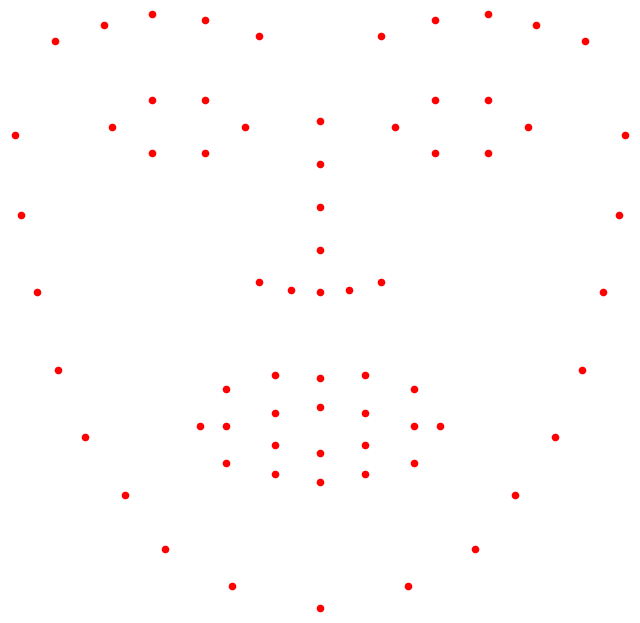

In [ ]:
from shapely.geometry import Point, Polygon

with open("prototype.json", "r") as f:
    prototype = np.array(json.load(f))

new_keypoints = prototype.copy()
w = new_keypoints[:, 0].max()
h = new_keypoints[:, 1].max()

plt.figure(figsize=(8, 8))

# Draw keypoints
for idx, (x, y) in enumerate(new_keypoints):
    plt.scatter(x, y, color='red', s=20, zorder=1)
    # plt.text(x, y, str(idx), color='blue', fontsize=6, ha='center', va='center')

# Delaunay triangulation
tri = Delaunay(new_keypoints)
plt.triplot(new_keypoints[:, 0], new_keypoints[:, 1], tri.simplices, color='gray', linewidth=1.2, zorder=0)

# Uniformly sample k=5 keypoints inside the prototype polygon

k = 5
boundary_polygon = Polygon(new_keypoints)
min_x, min_y = new_keypoints.min(axis=0)
max_x, max_y = new_keypoints.max(axis=0)

samples = []
while len(samples) < k:
    x = rng.uniform(min_x, max_x)
    y = rng.uniform(min_y, max_y)
    if boundary_polygon.contains(Point(x, y)):
        samples.append([x, y])
samples = np.array(samples)

# Draw sampled points and highlight triangles containing them
for pt in samples:
    plt.scatter(pt[0], pt[1], color='blue', s=40, zorder=3)
    simplex = tri.find_simplex(pt)
    if simplex != -1:
        triangle_indices = tri.simplices[simplex]
        triangle = new_keypoints[triangle_indices]
        plt.fill(triangle[:, 0], triangle[:, 1], color='yellow', alpha=0.3, zorder=2)

plt.gca().set_aspect('equal')
plt.axis('off')
plt.xlim(-2, w+2)
plt.ylim(h+2, -2)
plt.savefig("tmp/prototype_delaunay.svg", format="svg", bbox_inches='tight')
plt.show()

Max mean error: 0.17872485409360267
Min mean error (non-zero): 0.0009499328001002869
Max count: 66.0
Min count (non-zero): 1.0
Top 0.1% threshold in mean_map: 0.14785195918147717


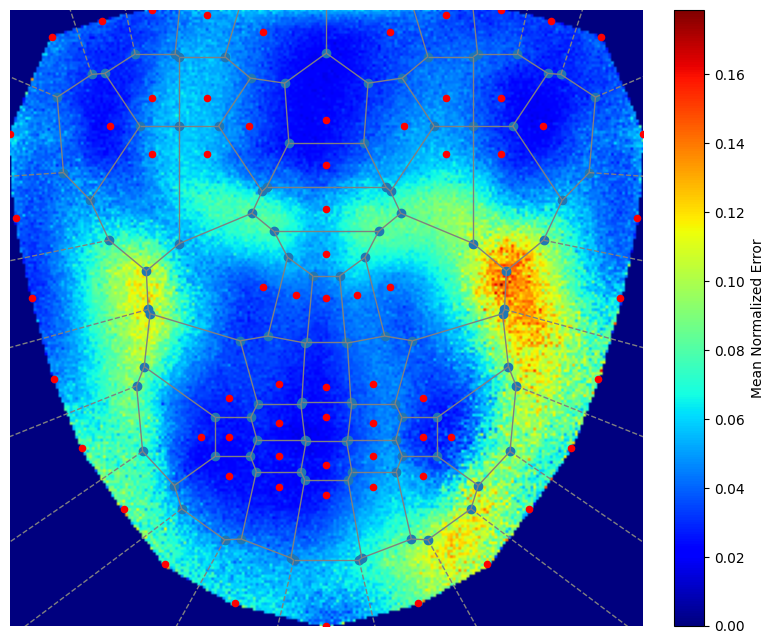

In [16]:
from scipy.spatial import Voronoi, voronoi_plot_2d

count_map = np.zeros((int(h)+1, int(w)+1))
sum_map = np.zeros((int(h)+1, int(w)+1))

for result in result_keypoints:
    gt = np.array(result['gt'])[start_kpts_idx:]
    pred = np.array(result['pred'])[start_kpts_idx:]
    bbox = result['bbox']
    max_side = max(bbox[2], bbox[3])
    error = np.linalg.norm(gt - pred, axis=1) / max_side
    # error = np.linalg.norm(gt - pred, axis=1)
    
    weights = result['weights']

    assert len(error) == len(weights)
    for id, (idxs, weight) in enumerate(weights):
        pts = new_keypoints[idxs]
        weighted_mean = np.dot(weight, pts)
        x, y = int(np.round(weighted_mean[0])), int(np.round(weighted_mean[1]))
        if 0 <= x < count_map.shape[1] and 0 <= y < count_map.shape[0]:
            # if error[id] > 2: continue
            count_map[y, x] += 1
            sum_map[y, x] += error[id]

# mean_map = np.where(count_map > 0, sum_map / count_map, 0)
mean_map = np.zeros_like(sum_map, dtype=float)
np.divide(sum_map, count_map, out=mean_map, where=(count_map > 0))

print("Max mean error:", mean_map.max())
print("Min mean error (non-zero):", mean_map[mean_map > 0].min())

print("Max count:", count_map.max())
print("Min count (non-zero):", count_map[count_map > 0].min())

# Find the value corresponding to the top 0.1% largest numbers in mean_map (excluding zeros)
nonzero_values = mean_map[mean_map > 0]
percentile_99_9 = np.percentile(nonzero_values, 99.9)
print("Top 0.1% threshold in mean_map:", percentile_99_9)

# threshold = percentile_99_9
# print(f"Number of outliers (error > {threshold}): {np.sum(mean_map > threshold)}/{np.sum(count_map > 0)}")
# print(f"Ratio of outliers (error > {threshold}):", np.sum(mean_map > threshold) / np.sum(count_map > 0))
# mean_map = np.clip(mean_map, 0, threshold)


# Compute Voronoi diagram for new_keypoints
vor_new = Voronoi(new_keypoints)

plt.figure(figsize=(10, 8))
# Plot mean error map as background (flip vertically to correct orientation)
im = plt.imshow(mean_map, cmap='jet')
# plt.imshow(count_map)
plt.scatter(new_keypoints[:, 0], new_keypoints[:, 1], color='red', s=20, label='Keypoints')
# Overlay Voronoi diagram (without points/vertices)
voronoi_plot_2d(vor_new, show_points=False, show_vertices=True, line_colors='gray', ax=plt.gca())

plt.axis('off')
plt.xlim(0, w)
plt.ylim(h, 0)
plt.colorbar(im, fraction=0.046, pad=0.04, label='Mean Normalized Error')

plt.savefig("tmp/voronoi_mean_error.svg", format="svg", bbox_inches='tight')

plt.show()

(1500000,) (1500000,)
Distance to Nearest Keypoint: min 0.01395175778459967, max 42.23913273095931, mean 14.031189194570837
Normalized Error: min 3.9301967727981146e-05, max 0.8246246997844479, mean 0.05385013912801456


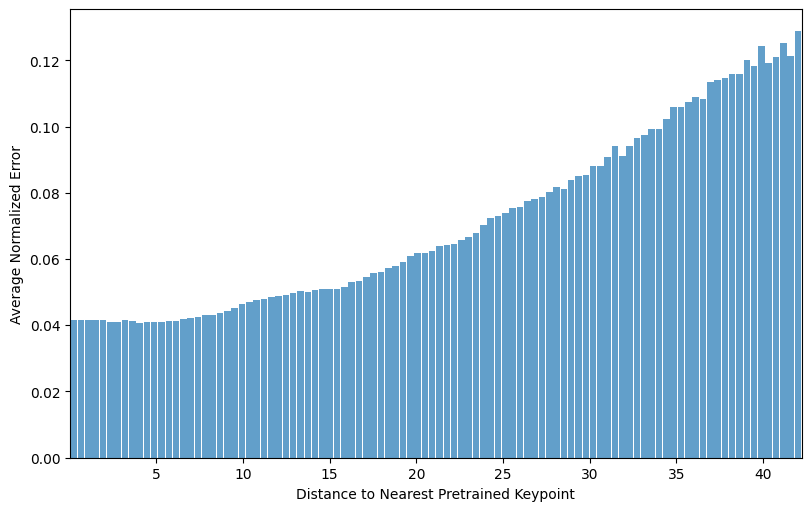

In [17]:
dists = []
errors = []

for result in result_keypoints:
    gt = np.array(result['gt'])[start_kpts_idx:]
    pred = np.array(result['pred'])[start_kpts_idx:]
    bbox = result['bbox']
    max_side = max(bbox[2], bbox[3])
    error = np.linalg.norm(gt - pred, axis=1) / max_side
    # error = np.linalg.norm(gt - pred, axis=1)

    errors.append(error)
    # print(error.shape)

    weights = result['weights']

    assert len(error) == len(weights)
    for id, (idxs, weight) in enumerate(weights):
        pts = new_keypoints[idxs]
        weighted_mean = np.dot(weight, pts)
        if 0 <= x < count_map.shape[1] and 0 <= y < count_map.shape[0]:
            # Find nearest keypoint in new_keypoints
            dist = np.linalg.norm(new_keypoints - weighted_mean, axis=1)
            nearest_dist = np.min(dist)
            dists.append(nearest_dist)

dists = np.hstack(dists)
errors = np.hstack(errors)

print(dists.shape, errors.shape)

print(f"Distance to Nearest Keypoint: min {dists.min()}, max {dists.max()}, mean {dists.mean()}")
print(f"Normalized Error: min {errors.min()}, max {errors.max()}, mean {errors.mean()}")


# # plt.figure(figsize=(10, 5))
# plt.figure(figsize=(8, 6))
# hi = plt.hist2d(dists, errors, bins=500, cmap='viridis')
# plt.xlabel('Distance to Nearest Keypoint')
# plt.ylabel('Normalized Error')
# plt.colorbar(label='Count')
# # plt.ylim(0, 0.4)

# # rasterize only the collection (h[3] is the QuadMesh)
# hi[3].set_rasterized(True)

# plt.savefig("tmp/error_vs_distance_hist2d.svg", dpi=150, bbox_inches='tight')
# plt.show()


# # 1. Define bins for distances
num_bins = 100   # you can adjust this
bin_edges = np.linspace(dists.min(), dists.max(), num_bins + 1)

# # 2. Digitize distances into bins
bin_indices = np.digitize(dists, bin_edges)

# # 3. Compute average error per bin

cnt_per_bin = []

bin_centers = []
avg_errors = []
for i in range(1, len(bin_edges)):
    mask = bin_indices == i
    if np.any(mask):
        bin_center = (bin_edges[i-1] + bin_edges[i]) / 2
        bin_centers.append(bin_center)
        avg_errors.append(errors[mask].mean())
        cnt_per_bin.append(mask.sum())

bin_centers = np.array(bin_centers)
avg_errors = np.array(avg_errors)
# cnt_per_bin = np.array(cnt_per_bin)
# print("Counts per bin:", cnt_per_bin)
# # 4. Plot histogram / line plot of average error vs. distance bin
# plt.figure(figsize=(8, 6))
# plt.bar(bin_centers, avg_errors, width=(bin_edges[1]-bin_edges[0])*0.9, align='center', alpha=0.7)
# plt.xlabel("Distance to Nearest Keypoint")
# plt.ylabel("Average Normalized Error")
# # plt.title("Average Error vs. Distance Bin")
# # plt.ylim(bottom=0.06)
# plt.savefig("tmp/average_error_vs_distance_bin.svg", format="svg", bbox_inches='tight')
# plt.show()

fig, axes = plt.subplots(1, 1, figsize=(8, 5), constrained_layout=True)

# # --- First plot: 2D histogram ---
# hi = axes[0].hist2d(dists, errors, bins=500, cmap='viridis')
# axes[0].set_xlabel('Distance to Nearest Keypoint')
# axes[0].set_ylabel('Normalized Error')
# cbar = fig.colorbar(hi[3], ax=axes[0], label='Count')
# hi[3].set_rasterized(True)

# --- Second plot: Average error per distance bin ---
axes.bar(
    bin_centers,
    avg_errors,
    width=(bin_edges[1]-bin_edges[0])*0.9,
    align='center',
    alpha=0.7
)
axes.set_xlabel("Distance to Nearest Pretrained Keypoint")
axes.set_ylabel("Average Normalized Error")

# --- Align x-axis range for both plots ---
xmin, xmax = dists.min(), dists.max()
axes.set_xlim(xmin, xmax)
# axes[1].set_xlim(xmin, xmax)
# axes[0].set_ylim(0, 0.4)
axes.set_ylim(bottom=0)

# Save and show
plt.savefig("tmp/error_vs_distance_grid.svg", dpi=150, bbox_inches='tight')
plt.show()


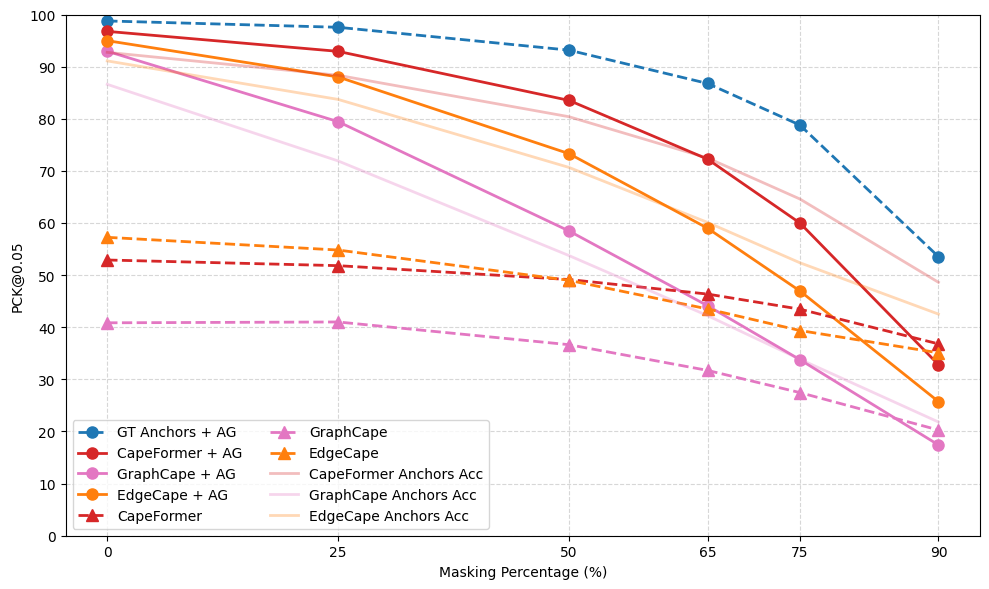

In [36]:
x_axis = [0, 25, 50, 65, 75, 90]

data = [
    {
        "name": "GT Anchors + AG",
        "PCK@0.05": [0.987606, 0.9755, 0.9316, 0.8677, 0.7879, 0.5354],
        "marker": "o",
        "color": "tab:blue",
        "type": "dashed",
    },
    {
        "name": "CapeFormer + AG",
        "PCK@0.05": [0.967652, 0.9293, 0.8352, 0.7225, 0.6000, 0.3282],
        "marker": "o",
        "color": "tab:red",
        "type": "solid",
    },
    {
        "name": "GraphCape + AG",
        "PCK@0.05": [0.9295, 0.7944, 0.5847, 0.4413, 0.3378, 0.1742],
        "marker": "o",
        "color": "tab:pink",
        "type": "solid",
    },
    {
        "name": "EdgeCape + AG",
        "PCK@0.05": [0.9498, 0.8802, 0.7330, 0.5900, 0.4696, 0.2574],
        "marker": "o",
        "color": "tab:orange",
        "type": "solid",
    },
    {
        "name": "CapeFormer",
        "PCK@0.05": [0.528982, 0.518142, 0.491524, 0.4636266667, 0.4346646667, 0.3680746667],
        "marker": "^",
        "color": "tab:red",
        "type": "dashed",
    },
    {
        "name": "GraphCape",
        "PCK@0.05": [0.4085, 0.4101, 0.3665, 0.3172, 0.2746, 0.2028],
        "marker": "^",
        "color": "tab:pink",
        "type": "dashed",
    },
    {
        "name": "EdgeCape",
        "PCK@0.05": [0.5725, 0.5481, 0.4900, 0.4351, 0.3937, 0.3509],
        "marker": "^",
        "color": "tab:orange",
        "type": "dashed",
    },
    {
        "name": "CapeFormer Anchors Acc",
        "PCK@0.05": [0.9274113725, 0.8834335294, 0.8038489216, 0.7247788889, 0.6460209804, 0.4861857143],
        "marker": "",
        "color": "tab:red",
        "type": "solid",
        "alpha": 0.3,
    },
    {
        "name": "GraphCape Anchors Acc",
        "PCK@0.05": [0.8660242157, 0.7190453595, 0.5374784314, 0.4222845833, 0.3386413725, 0.2181985714],
        "marker": "",
        "color": "tab:pink",
        "type": "solid",
        "alpha": 0.3,
    },
    {
        "name": "EdgeCape Anchors Acc",
        "PCK@0.05": [0.9109760784, 0.8370900654, 0.7065761765, 0.6011088889, 0.5236805882, 0.4252138095],
        "marker": "",
        "color": "tab:orange",
        "type": "solid",
        "alpha": 0.3,
    },
]


plt.figure(figsize=(10, 6))
for d in data:
    plt.plot(x_axis, np.array(d["PCK@0.05"]) * 100, marker=d["marker"], color=d["color"], label=d["name"], linewidth=2, markersize=8, linestyle=d["type"], alpha=d.get("alpha", 1.0))

plt.xlabel("Masking Percentage (%)")
plt.ylabel("PCK@0.05")
plt.xticks(x_axis)
plt.ylim(0, 100)
plt.yticks(np.arange(0, 110, 10))
plt.grid(True, linestyle="--", alpha=0.5)
plt.ylim(bottom=0)
plt.legend(ncol=2)
plt.tight_layout()
plt.savefig("tmp/pck_vs_masking.svg", format="svg", bbox_inches='tight')
plt.show()

In [3]:
import numpy as np

a = [349, 153, 1, 156, 131, 2, 221, 238, 2, 360, 312, 2, 504, 241, 2, 558, 114, 2, 110, 138, 2, 113, 454, 2, 104, 714, 2, 80, 984, 2, 372, 946, 2, 663, 955, 2, 641, 683, 2, 621, 436, 2, 609, 130, 2]
a = np.array(a).reshape(-1, 3)[:, :2]
b = [[x-58, y-82] for x, y in a]

# a = [[453, 185], [309, 145], [340, 279], [434, 380], [597, 249], [672, 110], [227, 173], [264, 486], [302, 702], [289, 927], [489, 1034], [737, 984], [686, 702], [654, 469], [767, 133]]
# b = [[x-58, y-82] for x, y in a]
print(b)

[[291, 71], [98, 49], [163, 156], [302, 230], [446, 159], [500, 32], [52, 56], [55, 372], [46, 632], [22, 902], [314, 864], [605, 873], [583, 601], [563, 354], [551, 48]]
